<h1 style="font-size:2rem; color:blue;"> Snow climatology using the ESA CCI Viewable snow product level L3C daily from AVHRR over the period 1982-2019 in the Mediterranean area without imputation of missing data </h1>

<h1 style="font-size:1.2rem; color:black;"> In this notebook, we will first explore the snow fraction data from the ESA CCI product. Then, we will make monthly, seasonal, and annual climatologies over the whole period 1982-2019.  </h1>   

## 1. Importing python moduls 

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import os 
import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import datetime as dt
import calendar as cld
import matplotlib.pyplot as plt
import xarray as xr
from os import listdir
from os.path import isfile, join
import cartopy.crs as ccrs
import cartopy 
import proplot as plot  # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import sys
import pymannkendall as mk
import calendar
import time

#import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
sys.path.insert(1, '/home/hamid/Desktop/results/') # to include my util file in previous directory

# ============================================================================
# Models for parallelisation
import multiprocessing 
from dask.distributed import Client
from dask import delayed
from dask import compute
# client = Client(n_workers=4, threads_per_worker=3, memory_limit='4GB')
client = Client(n_workers=16, threads_per_worker=1, memory_limit='2GB')
# client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46087,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:33129,Total threads: 1
Dashboard: http://127.0.0.1:44945/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:45173,


In [2]:
client.close()

## 2. Check and import data 

In [3]:
# Path to data
path_snow_CCI = '/home/hamid/dap.ceda.ac.uk/neodc/esacci/snow/data/scfv/AVHRR_MERGED/v2.0'
month = ["01","02","03","04","05","06","07","08","09","10","11","12"]
startyear = 2000
endyear = 2006
period = endyear - startyear + 1

ds0 = xr.open_mfdataset(path_snow_CCI+'/'+str(startyear)+'/01/*.nc')
for m in month[2:12]:
    aux = xr.open_mfdataset(path_snow_CCI+'/'+str(startyear)+'/'+m+'/*.nc')
    ds0=xr.concat([ds0, aux], dim='time')
print(str(startyear)+" scfv data is imported")
ds = ds0
year =startyear+1
#for year in range(startyear+1, endyear+1):
# !!! We have used an if condition to allow the 
# loop to skip the last two months of 1994, as no data is available 
while year < endyear+1:
    for m in month:
        if year == 1994 and m =="11":
            year=1995
        aux = xr.open_mfdataset(path_snow_CCI+'/'+str(year)+'/'+m+'/*.nc', parallel = True)
        ds=xr.concat([ds, aux], dim='time')
    print(str(year)+" scfv data is imported")
    year=year+1
print(ds)
print("==================================================================================")
ds  

2000 scfv data is imported
2001 scfv data is imported
2002 scfv data is imported
2003 scfv data is imported
2004 scfv data is imported
2005 scfv data is imported
2006 scfv data is imported
<xarray.Dataset>
Dimensions:      (time: 2522, lat: 3600, nv: 2, lon: 7200)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2006-12-31
  * lat          (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * lon          (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds     (time, lat, nv) float64 dask.array<chunksize=(1, 3600, 2), meta=np.ndarray>
    lon_bnds     (time, lon, nv) float64 dask.array<chunksize=(1, 7200, 2), meta=np.ndarray>
    scfv         (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    scfv_unc     (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    spatial_ref  (time) int32 -2147483647 -2147483647

<xarray.Dataset>
Dimensions:      (time: 2522, lat: 3600, nv: 2, lon: 7200)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2006-12-31
  * lat          (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * lon          (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds     (time, lat, nv) float64 dask.array<chunksize=(1, 3600, 2), meta=np.ndarray>
    lon_bnds     (time, lon, nv) float64 dask.array<chunksize=(1, 7200, 2), meta=np.ndarray>
    scfv         (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    scfv_unc     (time, lat, lon) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    spatial_ref  (time) int32 -2147483647 -2147483647 ... -2147483647
Attributes: (12/42)
    title:                      ESA CCI viewable snow product level L3C daily...
    institution:                Remote Sensing Research Group, Institute of G...
    source:                     AVHRR_NOAA-14_GAC mosaic from ESA Cloud CCI p...
    date_created:               20211112T104000Z
    history:                    20211112T104000Z: ESA snow_cci SCF processing...
    references:                 http://snow-cci.enveo.at/
    ...                         ...
    license:                    ESA CCI Data Policy: free and open access
    platform:                   NOAA-14
    sensor:                     AVHRR
    spatial_resolution:         0.05 degree
    key_variables:              scfv
    doi:                        10.5285/763eb87e0682446cafa8c74488dd5fb8

<h1 style="font-size:1.2rem; color:black;"> Define the weight of the leap years in our period  </h1> 

In [4]:
sum = 0
for year in range(startyear, endyear+1):
    if calendar.isleap(year):
        sum = sum+1
    else:
        sum = sum
weight = sum / (endyear - startyear +1)
print("the weight of leap years in our period is " + str(np.round(weight,3)))

the weight of leap years in our period is 0.286


<h1 style="font-size:1.2rem; color:black;"> Select variable (scfv in our case)  </h1>  

In [5]:
scfv = ds['scfv']
print("======================== scfv ============================")
scfv

======================== scfv ============================


<xarray.DataArray 'scfv' (time: 2522, lat: 3600, lon: 7200)>
dask.array<concatenate, shape=(2522, 3600, 7200), dtype=float32, chunksize=(1, 3600, 7200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2006-12-31
  * lat      (lat) float64 -89.97 -89.93 -89.88 -89.82 ... 89.88 89.93 89.97
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Attributes:
    long_name:            Snow Cover Fraction Viewable
    units:                percent
    standard_name:        snow_area_fraction_viewable_from_above
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfv_unc

  ## 3. Subset (In case the input data is global)

<h1 style="font-size:1.2rem; color:black;"> Here we define the latitudinal and longitudinal limits of the region of interest (We will focuse about Moroccan Atlas, Alpes and Pyrenees)</h1>  

In [6]:
# In case, the input data is global
# For Moroccan Atlas
latlim = slice(30,36)
lonlim = slice(-10, -4)
scfv_subset = scfv.sel(lat=latlim, lon=lonlim).load()

scfv_subset

"""
# Alpes
latlim = slice(28,36)
lonlim = slice(-10, 0)
scfv_subset = da.sel(lat=latlim, lon=lonlim).load()
scfv_subset = scfv.sel(lat=latlim, lon=lonlim).load()

scfv_subset
"""
"""
# Pyrenees
latlim = slice(28,36)
lonlim = slice(-10, 0)
scfv_subset = da.sel(lat=latlim, lon=lonlim).load()
scfv_subset = scfv.sel(lat=latlim, lon=lonlim).load()

scfv_subset
"""

'\n# Pyrenees\nlatlim = slice(28,36)\nlonlim = slice(-10, 0)\nscfv_subset = da.sel(lat=latlim, lon=lonlim).load()\nscfv_subset = scfv.sel(lat=latlim, lon=lonlim).load()\n\nscfv_subset\n'

In [7]:
scfv_subset

<xarray.DataArray 'scfv' (time: 2522, lat: 120, lon: 120)>
array([[[210., 210., 210., ...,   0.,   0.,   0.],
        [210., 210., 210., ...,   0.,   0.,   0.],
        [210., 210., 210., ...,   0.,   0.,   0.],
        ...,
        [210., 210., 210., ..., 210., 210., 210.],
        [210., 210., 210., ..., 210., 210., 210.],
        [210., 210., 210., ..., 210., 210., 210.]],

       [[210., 210., 210., ...,   0.,   0.,   0.],
        [210., 210., 210., ...,   0.,   0.,   0.],
        [210., 210., 210., ...,   0.,   0.,   0.],
        ...,
        [210., 210., 210., ..., 210., 210., 210.],
        [210., 210., 210., ..., 210., 210., 210.],
        [210., 210., 210., ..., 210., 210., 210.]],

       [[210., 210., 210., ...,   0.,   0.,   0.],
        [210., 210., 210., ...,   0.,   0.,   0.],
        [210., 210., 210., ...,   0.,   0.,   0.],
        ...,
...
        ...,
        [210., 210., 210., ..., 210., 210., 210.],
        [210., 210., 210., ..., 210., 210., 210.],
        [210., 210., 210., ..., 210., 210., 210.]],

       [[210., 210., 210., ...,   0.,   0.,   0.],
        [210., 210., 210., ...,   0.,   0.,   0.],
        [210., 210., 210., ...,   0.,   0.,   0.],
        ...,
        [210., 210., 210., ..., 210., 210., 210.],
        [210., 210., 210., ..., 210., 210., 210.],
        [210., 210., 210., ..., 210., 210., 210.]],

       [[210., 210., 210., ...,   0.,   0.,   0.],
        [210., 210., 210., ...,   0.,   0.,   0.],
        [210., 210., 210., ...,   0.,   0.,   0.],
        ...,
        [210., 210., 210., ..., 210., 210., 210.],
        [210., 210., 210., ..., 210., 210., 210.],
        [210., 210., 210., ..., 210., 210., 210.]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2006-12-31
  * lat      (lat) float64 30.02 30.08 30.12 30.17 ... 35.83 35.88 35.92 35.97
  * lon      (lon) float64 -9.975 -9.925 -9.875 -9.825 ... -4.125 -4.075 -4.025
Attributes:
    long_name:            Snow Cover Fraction Viewable
    units:                percent
    standard_name:        snow_area_fraction_viewable_from_above
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfv_unc

<h1 style="font-size:1.2rem; color:black;"> Store scfv_subset in netcdf files in the hard disk </h1>

In [9]:
# Directory
directory = "intermediate_files"
  
# Parent Directory path
parent_dir = "/home/hamid/Desktop/"
  
# Path
path = os.path.join(parent_dir, directory)
 
# Create the directory in '/home / User / Desktop'
os.mkdir(path)
print("Directory '% s' created" % directory)

Directory 'intermediate_files' created


In [10]:
scfv_subset.to_netcdf(path + "/scfv_atlas.nc")

In [11]:
scfv_atlas = xr.open_dataset(path + "/scfv_atlas.nc")
scfv_atlas

<xarray.Dataset>
Dimensions:  (time: 2522, lat: 120, lon: 120)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2006-12-31
  * lat      (lat) float64 30.02 30.08 30.12 30.17 ... 35.83 35.88 35.92 35.97
  * lon      (lon) float64 -9.975 -9.925 -9.875 -9.825 ... -4.125 -4.075 -4.025
Data variables:
    scfv     (time, lat, lon) float32 ...

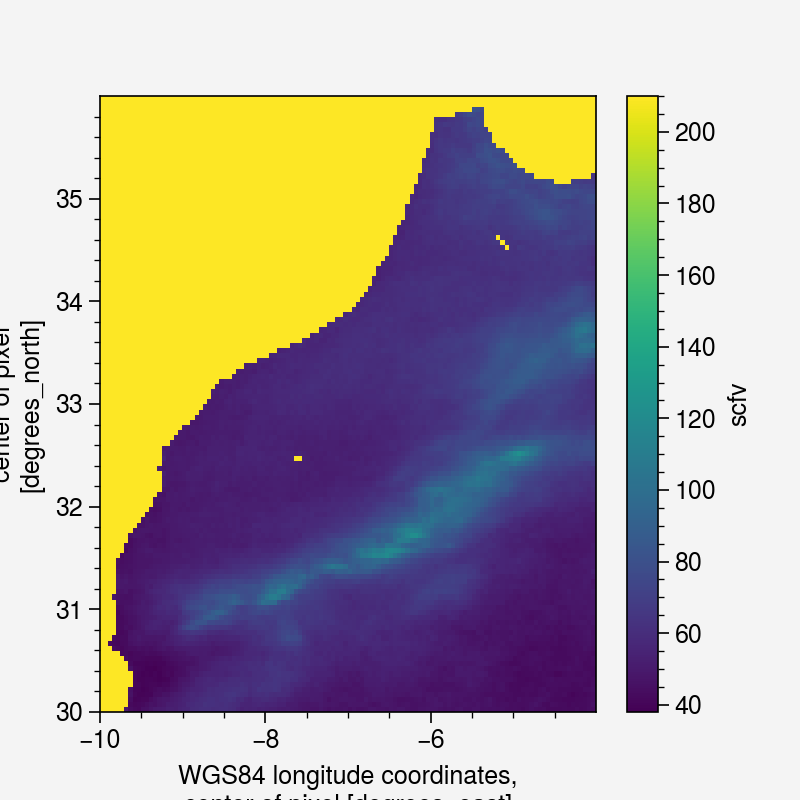

In [12]:
aux = scfv_atlas.mean(dim = 'time')
aux.scfv.plot()

<h1 style="font-size:1.2rem; color:black;"> We create another dataset that contains only the values between 0 and 100% of scfv </h1>

In [13]:
scfv_atlas_filtred = scfv_atlas.where(scfv_atlas <= 100)

In [14]:
scfv_atlas_filtred

<xarray.Dataset>
Dimensions:  (time: 2522, lat: 120, lon: 120)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2006-12-31
  * lat      (lat) float64 30.02 30.08 30.12 30.17 ... 35.83 35.88 35.92 35.97
  * lon      (lon) float64 -9.975 -9.925 -9.875 -9.825 ... -4.125 -4.075 -4.025
Data variables:
    scfv     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

<h1 style="font-size:1.2rem; color:black;"> Store scfv_atlas_filtred in netcdf files in the hard disk </h1>

In [15]:
scfv_atlas_filtred.to_netcdf(path + "/scfv_atlas_filtred.nc")

<h1 style="font-size:1.2rem; color:black;"> Quick viewing of mean in time </h1>

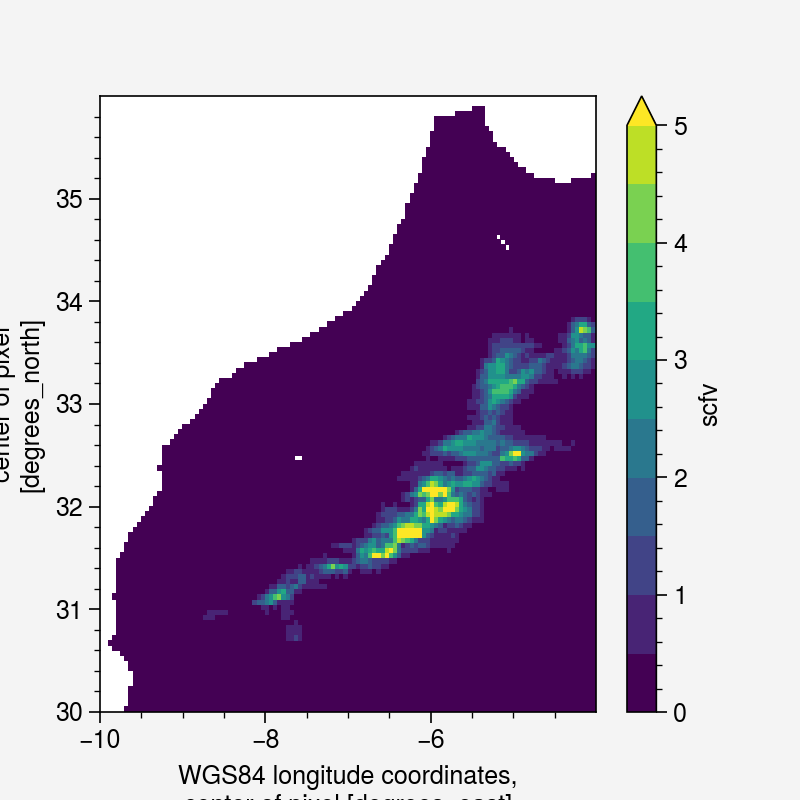

In [16]:
scfv_atlas_filtred.scfv.mean(dim='time').plot(levels=plot.arange(0, 5,0.5))

## 3. Data coverage

In [17]:
aux = scfv_atlas_filtred.count(dim='time')
aux.scfv.values 

array([[   0,    0,    0, ..., 2008, 1991, 2001],
       [   0,    0,    0, ..., 2009, 2002, 1980],
       [   0,    0,    0, ..., 2009, 1999, 1991],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 120)
Coordinates:
  * lat      (lat) float64 30.02 30.08 30.12 30.17 ... 35.83 35.88 35.92 35.97
  * lon      (lon) float64 -9.975 -9.925 -9.875 -9.825 ... -4.125 -4.075 -4.025
Data variables:
    scfv     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    units:    %


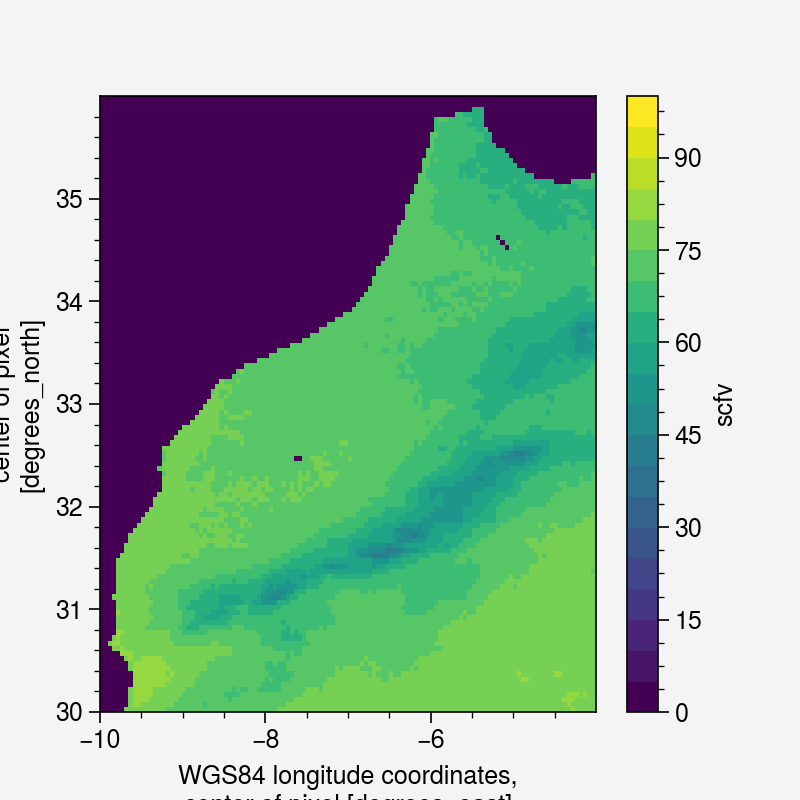

In [18]:
data_coverage = ((scfv_atlas_filtred.count(dim='time') / scfv_atlas.time.size)*100)
data_coverage.scfv.name = 'Data coverage'
data_coverage.attrs['units'] = '%'

print(data_coverage)

data_coverage.scfv.plot(levels=plot.arange(0, 100, 5))

<h1 style="font-size:1.2rem; color:black;"> Store data_coverage in netcdf files in the hard disk </h1>

In [19]:
data_coverage.to_netcdf(path + "/data_covered_atlas.nc")

<h1 style="font-size:1.2rem; color:black;"> Percentage of covered data in each month over the hole periode (1982-2018)  </h1>

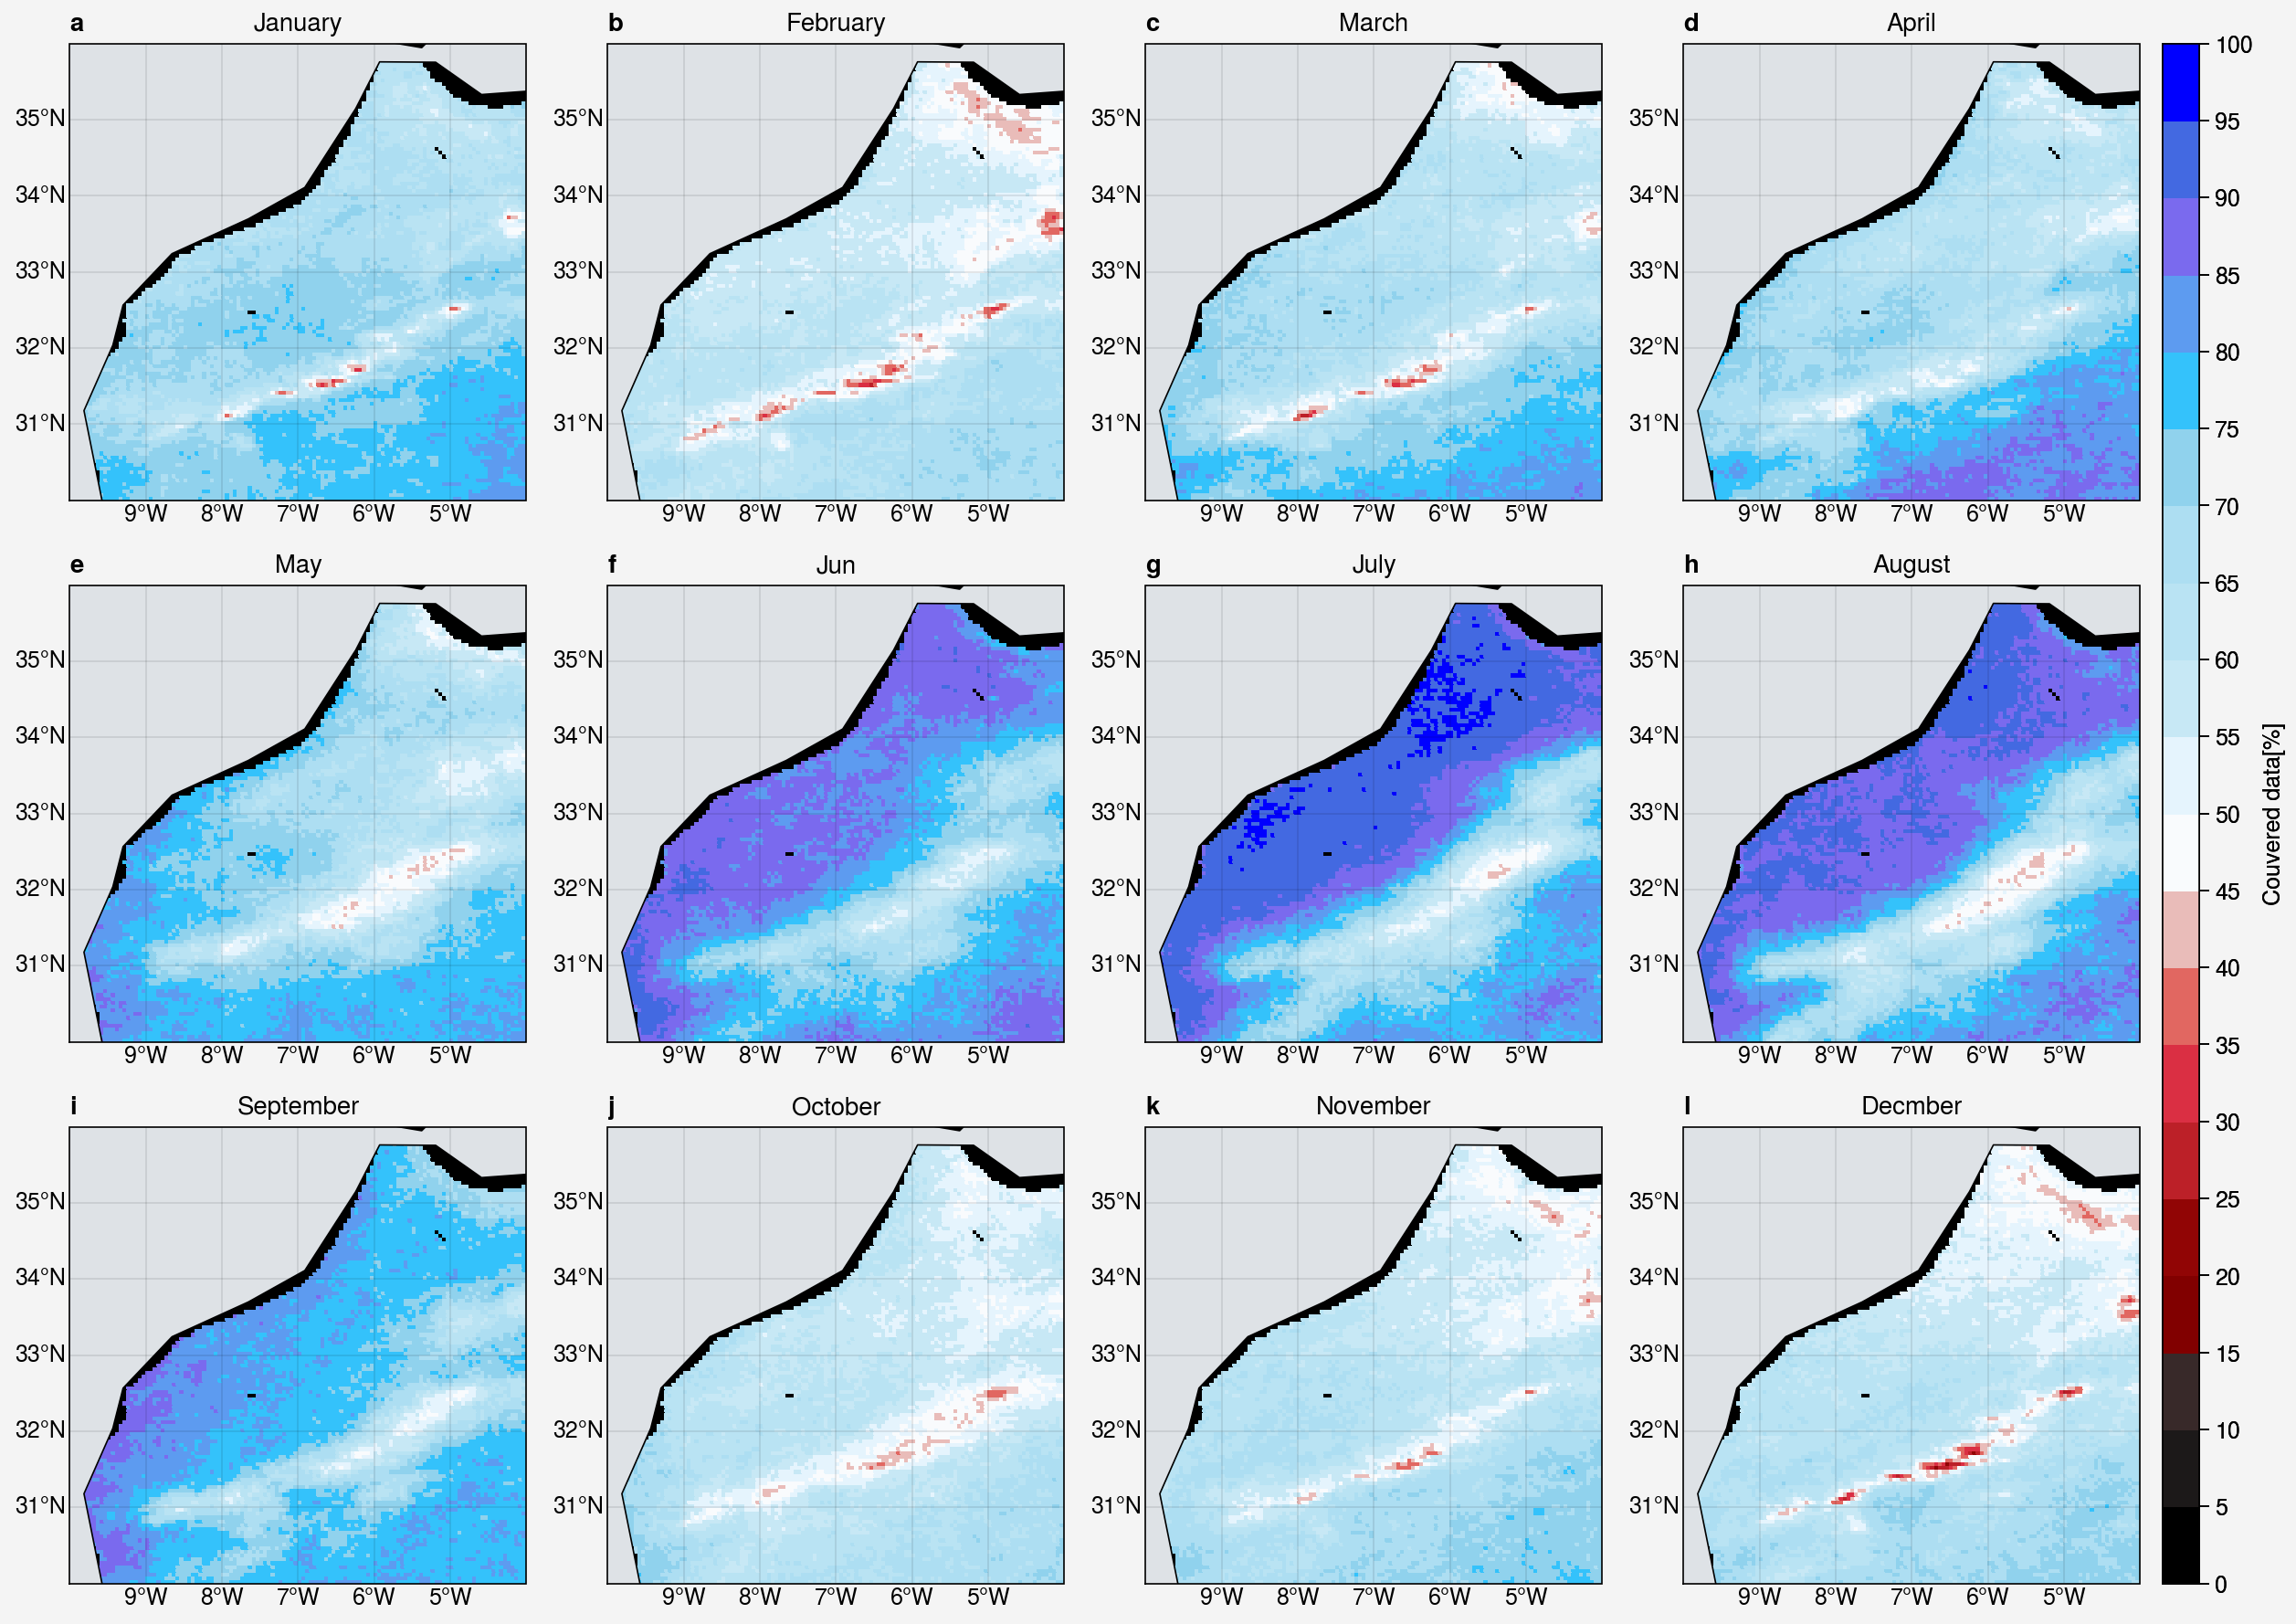

In [20]:
time_period = period                               
m1 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==1).count('time') / (31*time_period))*100).load()
m2 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==2).count('time') / ((28+weight)*time_period))*100).load()
m3 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==3).count('time') / (31*time_period))*100).load()
m4 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==4).count('time') / (30*time_period))*100).load()
m5 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==5).count('time') / (31*time_period))*100).load()
m6 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==6).count('time') / (30*time_period))*100).load()
m7 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==7).count('time') / (31*time_period))*100).load()
m8 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==8).count('time') / (31*time_period))*100).load()
m9 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==9).count('time') / (30*time_period))*100).load()
m10 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==10).count('time') / (31*time_period))*100).load()
m11 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==11).count('time') / (30*time_period))*100).load()
m12 = ((scfv_atlas_filtred.where(scfv_atlas_filtred['time.month']==12).count('time') / (31*time_period))*100).load()


cmap=[ "#000000", "#1C1919", "#352929","#800000","#8B0000", "#B22222",  "#DC143C","#CD5C5C","#FA8072", "#FFFFFF",  
      "#F0F8FF", "#dbf0f9","#b9e3f3","#b9e3f3", "#a9dcf1", "#87ceeb","#00BFFF","#6495ED","#7B68EE", "#4169E1", "#0000FF"]
#levels=[0, 5, 10, 15,20, 25, 30, 35, 40, 45,50 ,55 , 60,65,70,75, 80,85,90,95, 100]
levels=[0,5,10,15,20,25, 30,35,40,45,50,55, 60,65, 70,75,80,85, 90,95, 100]            
var_label = 'Couvered data[%]'
f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3)

mon = {1: "January", 2:"February", 3:"March", 4:"April", 5: "May", 6:"Jun", 7:"July", 8:"August", 9:"September",10:"October", 11:"November", 12:"Decmber"}   
var = {1: m1, 2:m2, 3:m3, 4:m4, 5: m5, 6:m6, 7:m7, 8:m8, 9:m9,10:m10, 11:m11, 12:m12}    
for i, ax in enumerate(axs):
    m = ax.pcolormesh(  
        var[i+1].scfv, 
        cmap=cmap,
        levels=levels,
        extend='neither'
        )
    ax.format(title=mon[i+1])
    
f.colorbar(m, label=var_label)    
axs.format(
    labels=True,                    
    coast=True, ocean=True, oceancolor='gray3', borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()


<h1 style="font-size:1.2rem; color:black;"> Percentage of masked pixels by clouds in each month over the hole periode (1982-2018)  </h1>

In [21]:
clouds_percentage = scfv_atlas.where(scfv_atlas == 205)

In [22]:
clouds_percentage

<xarray.Dataset>
Dimensions:  (time: 2522, lat: 120, lon: 120)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2006-12-31
  * lat      (lat) float64 30.02 30.08 30.12 30.17 ... 35.83 35.88 35.92 35.97
  * lon      (lon) float64 -9.975 -9.925 -9.875 -9.825 ... -4.125 -4.075 -4.025
Data variables:
    scfv     (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [23]:
clouds_percentage.to_netcdf(path + "/clouds_percentage.nc")

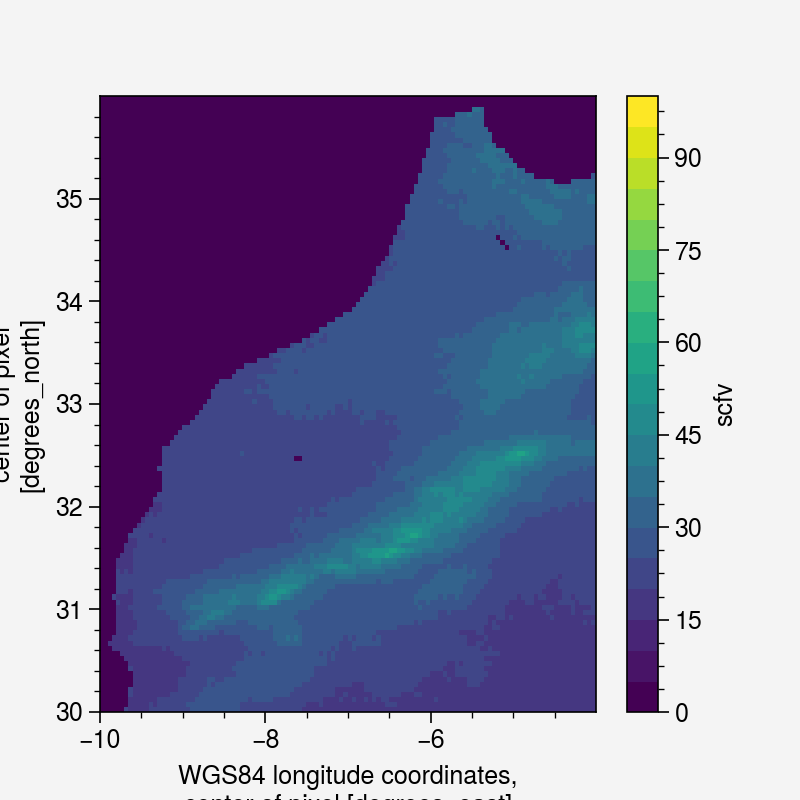

In [24]:
cloud_mask = ((clouds_percentage.count(dim='time') / scfv_atlas.time.size)*100)
cloud_mask.scfv.name = 'Data coverage'
cloud_mask.attrs['units'] = '%'

cloud_mask

cloud_mask.scfv.plot(levels=plot.arange(0, 100, 5))

<h1 style="font-size:1.2rem; color:black;"> Store cloud_mask in netcdf files in the hard disk </h1>

In [25]:
cloud_mask.to_netcdf(path + "/cloud_mask_atlas.nc")

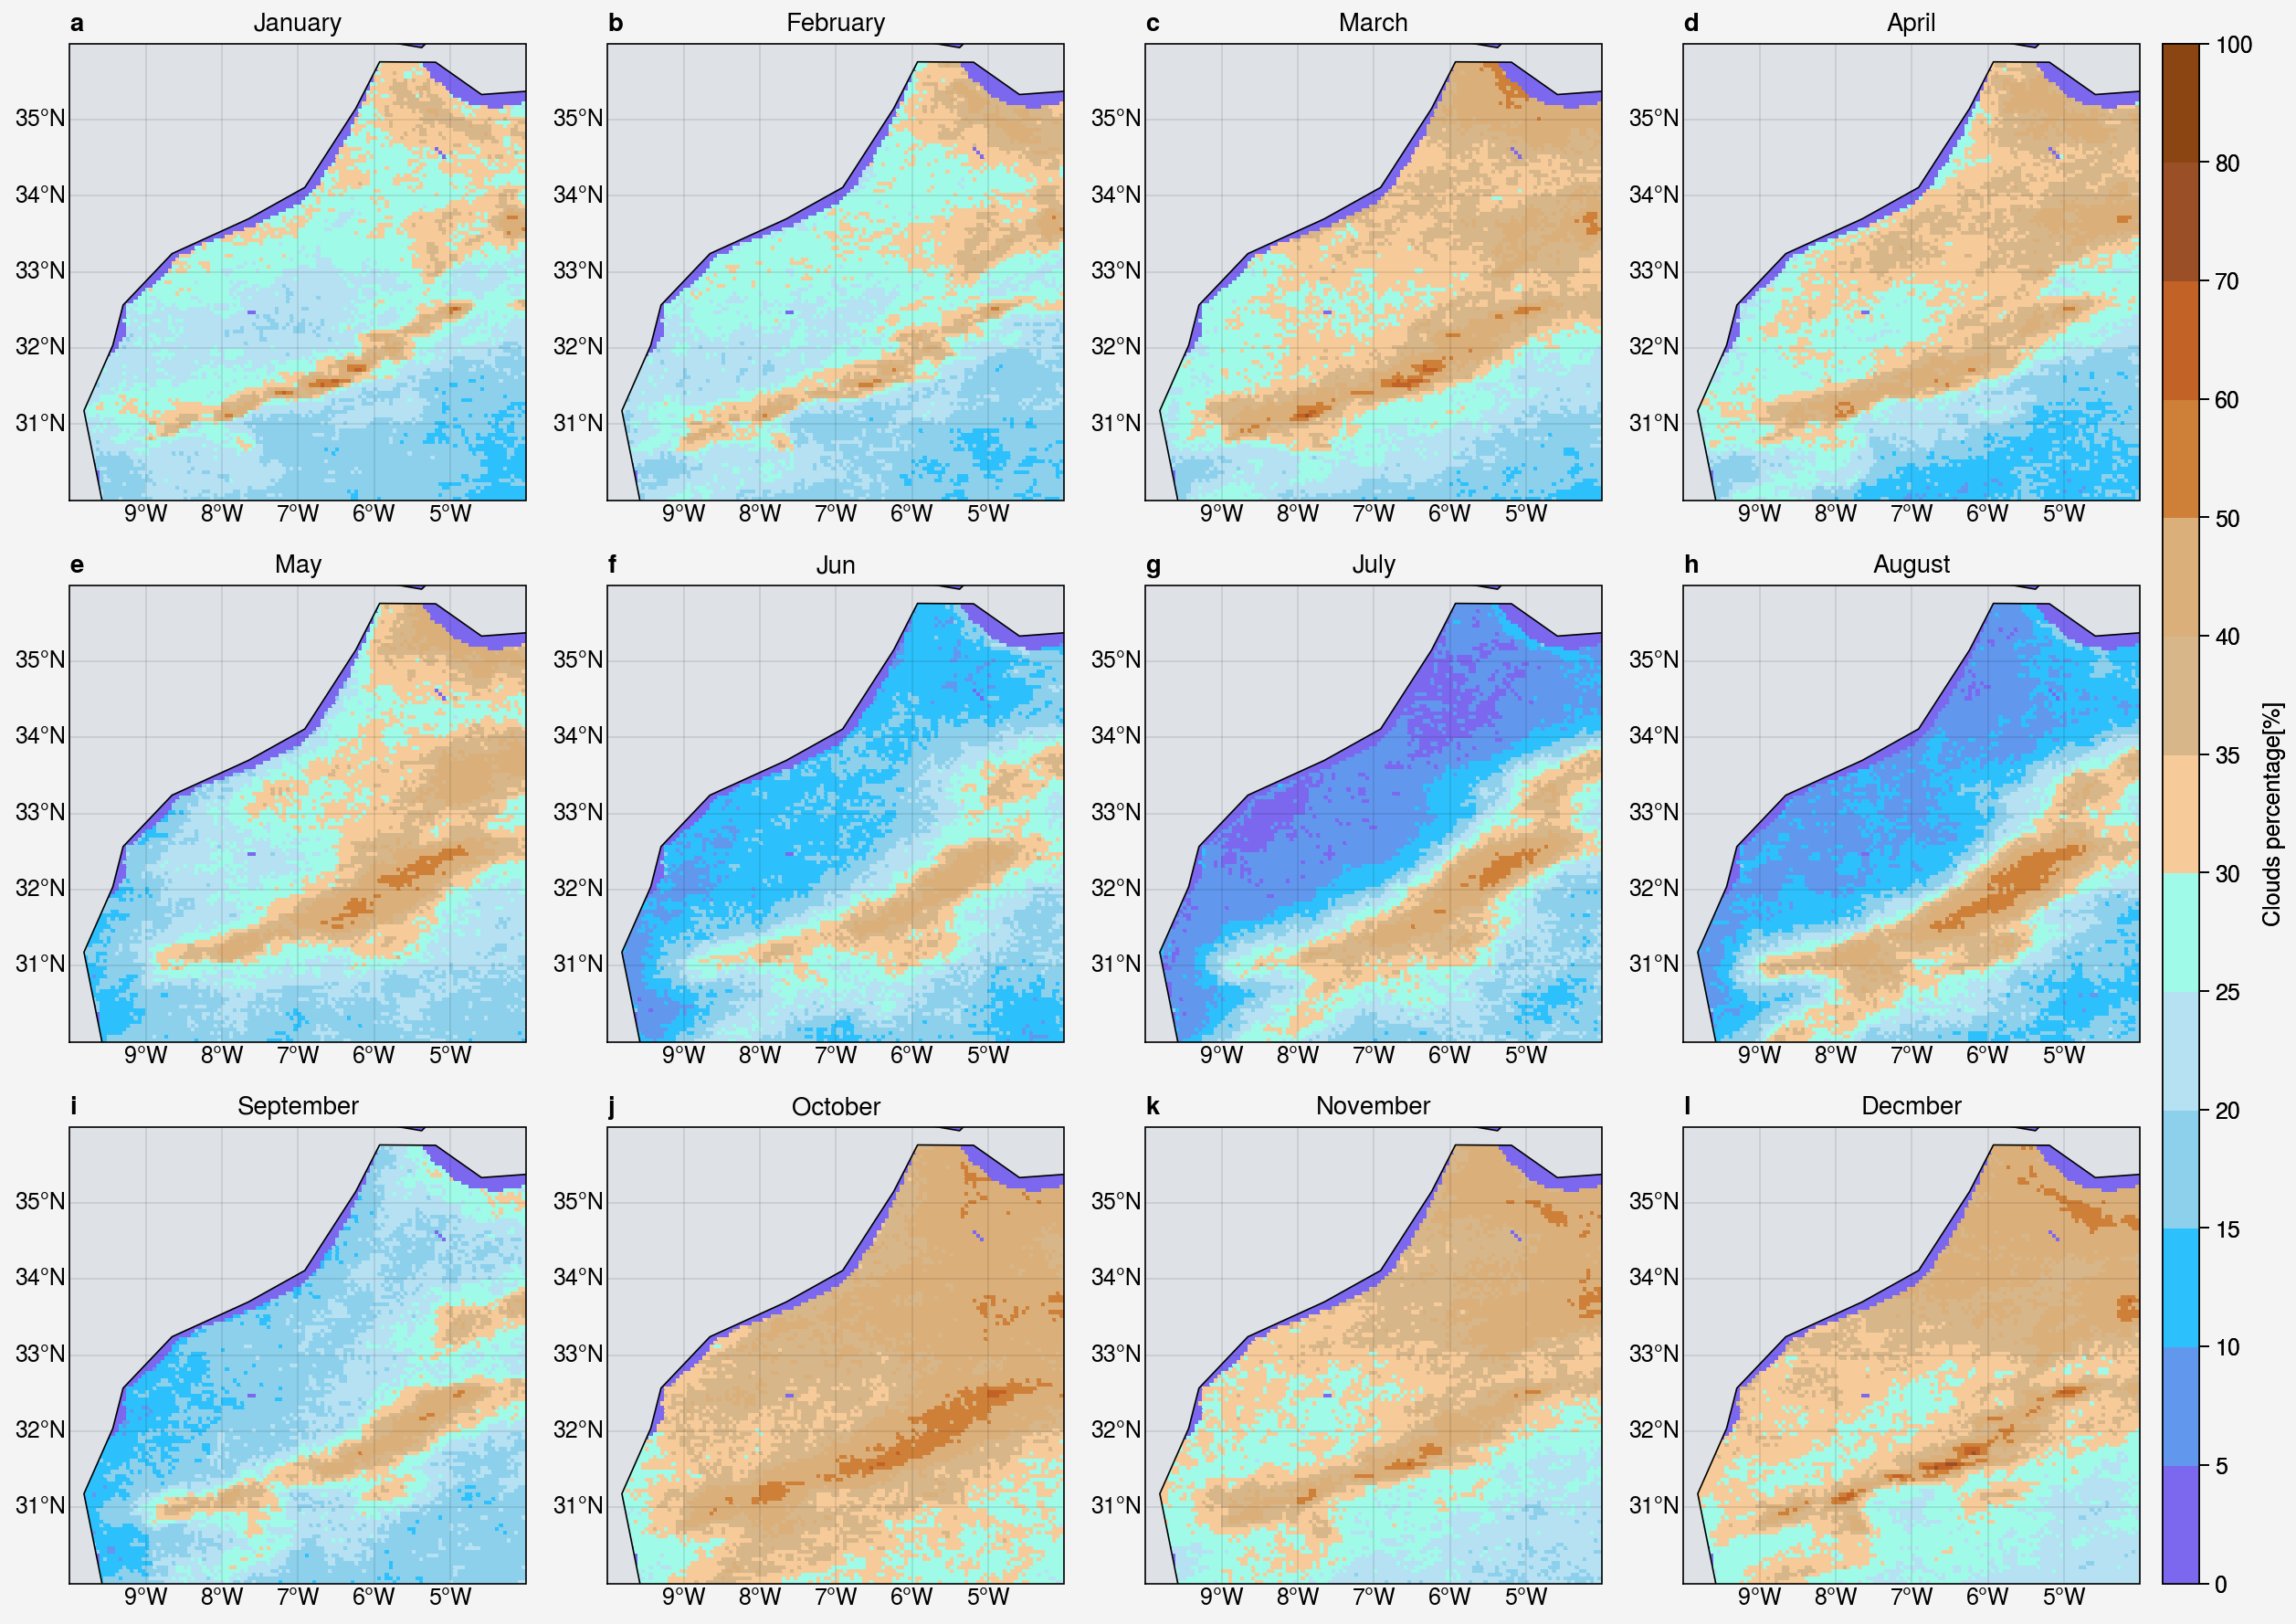

In [26]:
time_period = period                               
m1 = ((clouds_percentage.where(clouds_percentage['time.month']==1).count('time') / (31*time_period))*100).load()
m2 = ((clouds_percentage.where(clouds_percentage['time.month']==2).count('time') / ((28+weight)*time_period))*100).load()
m3 = ((clouds_percentage.where(clouds_percentage['time.month']==3).count('time') / (31*time_period))*100).load()
m4 = ((clouds_percentage.where(clouds_percentage['time.month']==4).count('time') / (30*time_period))*100).load()
m5 = ((clouds_percentage.where(clouds_percentage['time.month']==5).count('time') / (31*time_period))*100).load()
m6 = ((clouds_percentage.where(clouds_percentage['time.month']==6).count('time') / (30*time_period))*100).load()
m7 = ((clouds_percentage.where(clouds_percentage['time.month']==7).count('time') / (31*time_period))*100).load()
m8 = ((clouds_percentage.where(clouds_percentage['time.month']==8).count('time') / (31*time_period))*100).load()
m9 = ((clouds_percentage.where(clouds_percentage['time.month']==9).count('time') / (30*time_period))*100).load()
m10 = ((clouds_percentage.where(clouds_percentage['time.month']==10).count('time') / (31*time_period))*100).load()
m11 = ((clouds_percentage.where(clouds_percentage['time.month']==11).count('time') / (30*time_period))*100).load()
m12 = ((clouds_percentage.where(clouds_percentage['time.month']==12).count('time') / (31*time_period))*100).load()


cmap=["#7B68EE", "#6495ED", "#00BFFF","#87ceeb", "#a9dcf1", "#dbf0f9",
      "#FFDAB9", "#D2B48C", "#DEB887", "#CD853F", "#D2691E", "#A0522D", "#8B4513" ]
#levels=[0, 5, 10, 15, 20, 25, 30, 35, 40,50,60,70,80,100]
levels=[0, 5, 10, 15, 20, 25, 30, 35, 40,50,60,70,80,100]            
var_label = 'Clouds percentage[%]'
f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3)

mon = {1: "January", 2:"February", 3:"March", 4:"April", 5: "May", 6:"Jun", 7:"July", 8:"August", 9:"September",10:"October", 11:"November", 12:"Decmber"}   
var = {1: m1, 2:m2, 3:m3, 4:m4, 5: m5, 6:m6, 7:m7, 8:m8, 9:m9,10:m10, 11:m11, 12:m12}    
for i, ax in enumerate(axs):
    m = ax.pcolormesh(  
        var[i+1].scfv, 
        cmap=cmap,
        levels=levels,
        extend='neither'
        )
    ax.format(title=mon[i+1])
    
f.colorbar(m, label=var_label)    
axs.format(
    labels=True,                    
    coast=True, ocean=True, oceancolor='gray3', borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()


## 4. Monthly, seasonal and yearly averages over the period 1982-2018

<h1 style="font-size:1.2rem; color:black;"> Monthly average computing </h1> 

In [27]:
monthly_mean = scfv_atlas_filtred.groupby('time.month').mean(dim='time')

In [28]:
monthly_mean.scfv

<xarray.DataArray 'scfv' (month: 12, lat: 120, lon: 120)>
array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 30.02 30.08 30.12 30.17 ... 35.83 35.88 35.92 35.97
  * lon      (lon) float64 -9.975 -9.925 -9.875 -9.825 ... -4.125 -4.075 -4.025
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

<h1 style="font-size:1.2rem; color:black;"> Store monthly_mean in netcdf files in the hard disk </h1>

In [29]:
monthly_mean.to_netcdf(path + "/monthly_mean.nc")

<h1 style="font-size:1.2rem; color:black;"> Monthly average plot </h1>

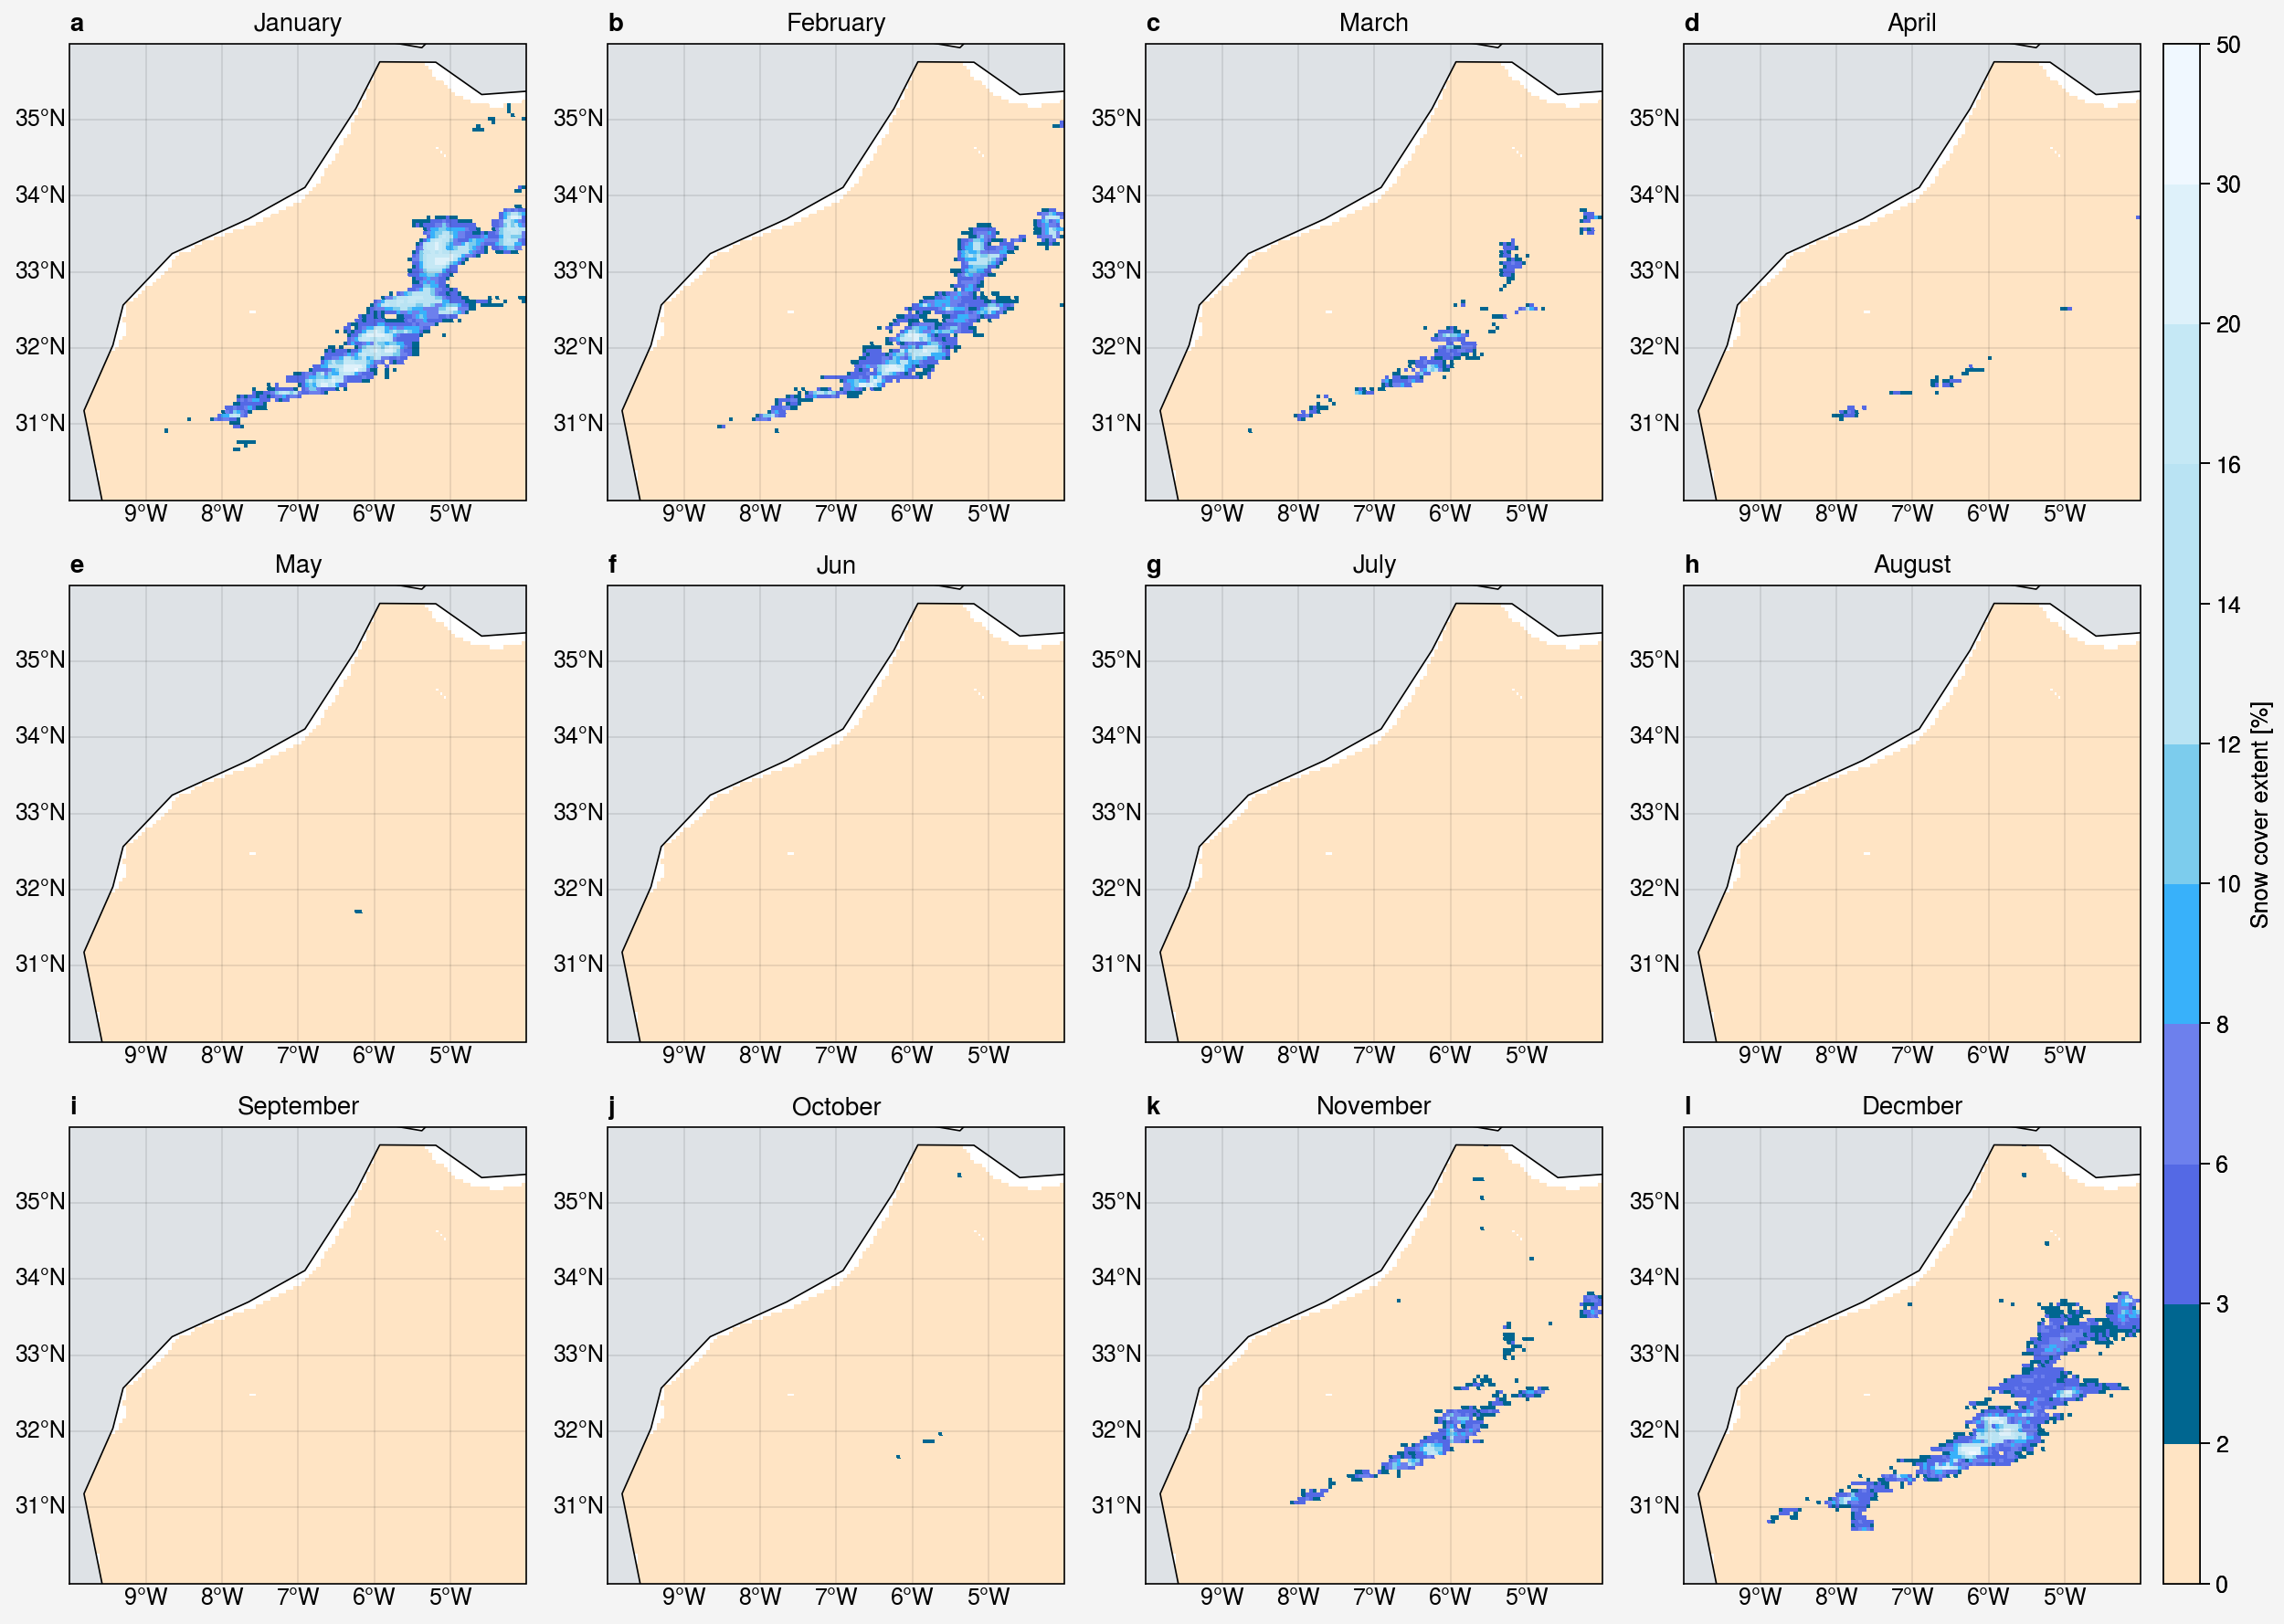

In [30]:
aux = monthly_mean

cmap=["bisque","#0000FF","#4169E1","#7B68EE","#6495ED","#00BFFF","#87ceeb","#b9e3f3","#b9e3f3","#dbf0f9",
"#F0F8FF"]
levels=[0, 2, 3, 6,8,10,12,14,16,20,30,50]          
var_label = 'Snow cover extent [%]'

f, axs = plot.subplots(proj='cyl', ncols=4, nrows=3)

dic = {1: "January", 2:"February", 3:"March", 4:"April", 5: "May", 6:"Jun", 7:"July", 8:"August", 9:"September",10:"October", 11:"November", 12:"Decmber"}   
for i, ax in enumerate(axs):
    m = ax.pcolormesh(  
        aux.scfv[i,:,:], 
        cmap=cmap,
        levels=levels,
        extend='neither'
        )
    ax.format(title=dic[i+1])
    
f.colorbar(m, label=var_label)

axs.format(  
    labels=True,                    
    coast=True, ocean=True, oceancolor='gray3', borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()

<h1 style="font-size:1.2rem; color:black;"> Seasonal average computing </h1>  

In [31]:
seasonal_mean = scfv_atlas_filtred.groupby('time.season').mean(dim='time')

In [32]:
seasonal_mean.scfv

<xarray.DataArray 'scfv' (season: 4, lat: 120, lon: 120)>
array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 30.02 30.08 30.12 30.17 ... 35.83 35.88 35.92 35.97
  * lon      (lon) float64 -9.975 -9.925 -9.875 -9.825 ... -4.125 -4.075 -4.025
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

<h1 style="font-size:1.2rem; color:black;"> Store seasonal_mean in netcdf files in the hard disk </h1>

In [33]:
seasonal_mean.to_netcdf(path + "/seasonal_mean.nc")

<h1 style="font-size:1.2rem; color:black;"> Seasonal average plot </h1>  

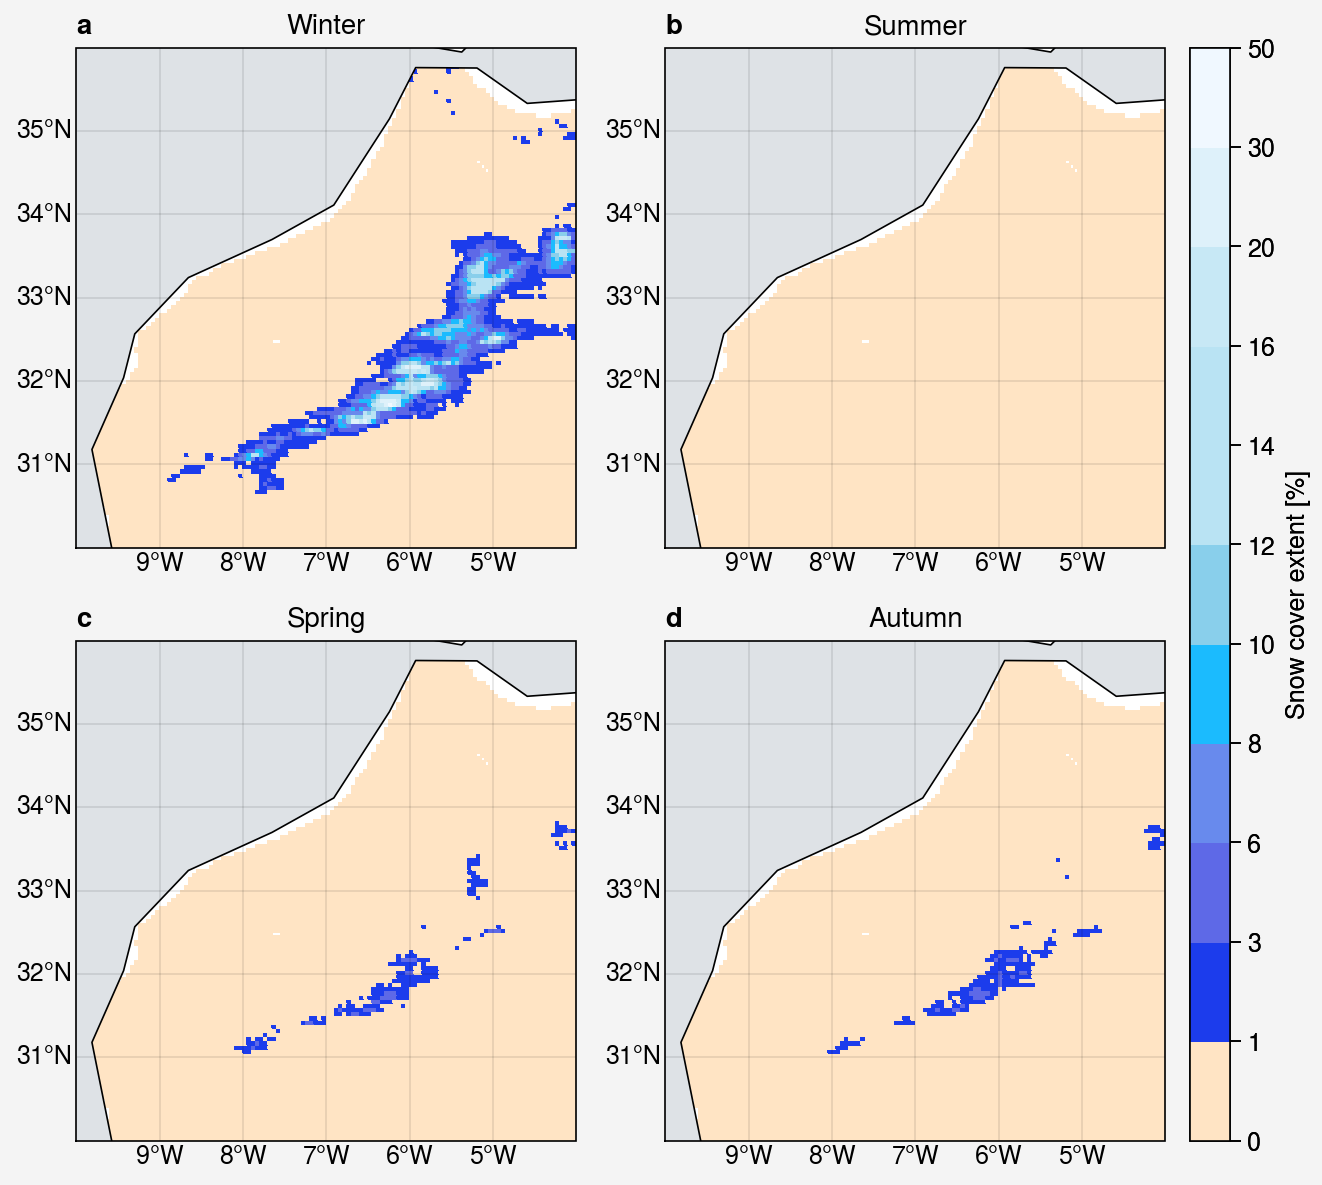

In [35]:
aux = seasonal_mean.scfv

cmap=["bisque","#0000FF","#4169E1","#7B68EE","#6495ED","#00BFFF","#87ceeb","#b9e3f3","#b9e3f3","#dbf0f9",
"#F0F8FF"]
levels=[0, 1, 3, 6,8,10,12,14,16,20,30,50]          
var_label = 'Snow cover extent [%]'

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2)

dic = {1: "Winter", 2:"Summer", 3:"Spring", 4:"Autumn"}   
for i, ax in enumerate(axs):
    m = ax.pcolormesh(  
        aux[i,:,:], 
        cmap=cmap,
        levels=levels,
        extend='neither'
        )
    ax.format(title=dic[i+1])
    
f.colorbar(m, label=var_label)

axs.format(          
    labels=True,                    
    coast=True, ocean=True, oceancolor='gray3', borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()


<h1 style="font-size:1.2rem; color:black;"> Yearly average plot </h1>  

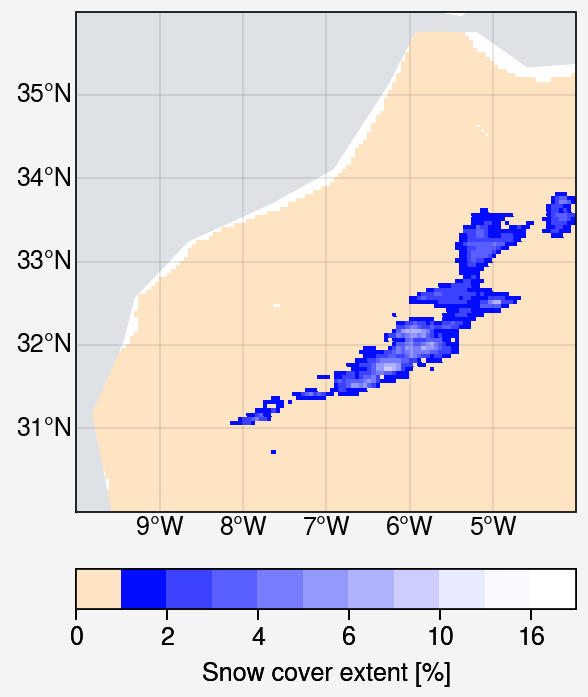

In [36]:
#ds = ds.sel(time=slice("1982-02-01","2019-12-31"))
aux = scfv_atlas_filtred.mean(dim='time')

cmap=["bisque","#0009FF", "#3940FF", "#575CFF", "#7378FF", "#9093FF","#ACAFFF", "#C9CAFF","#E5E6FF","#F7F9FF", "#FFFFFF"]
levels=[0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20]          
var_label = 'Snow cover extent [%]'

f, ax = plot.subplots(proj='cyl', ncols=1, nrows=1)

m = ax.pcolormesh(aux.scfv, cmap=cmap, levels=levels, extend='neither')
ax.format(title="")
    
f.colorbar(m, label=var_label, orientation='horizontal', location='bottom')

ax.format(
    labels=True,                    
    coast=False, ocean=True, oceancolor='gray3', borders=False,
    lonlines=1, latlines=1, abc=False, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()



## 5. Trends over the period 1982-2018 with mann-kandall test

<h1 style="font-size:1.2rem; color:black;"> Seasonal trends   </h1>   

In [98]:
aux = scfv_atlas_filtred.scfv
seas_scfv=np.empty(shape=(time_period,4,aux.shape[1],aux.shape[2]), dtype=float)
print(seas_scfv.shape)

(7, 4, 120, 120)


In [99]:
aux

<xarray.DataArray 'scfv' (time: 2522, lat: 120, lon: 120)>
array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2006-12-31
  * lat      (lat) float64 30.02 30.08 30.12 30.17 ... 35.83 35.88 35.92 35.97
  * lon      (lon) float64 -9.975 -9.925 -9.875 -9.825 ... -4.125 -4.075 -4.025
Attributes:
    long_name:            Snow Cover Fraction Viewable
    units:                percent
    standard_name:        snow_area_fraction_viewable_from_above
    valid_range:          [  0 254]
    actual_range:         [  0 100]
    flag_values:          [205 206 210 215 254]
    flag_meanings:        Cloud Polar_Night_or_Night Water Permanent_Snow_and...
    grid_mapping:         spatial_ref
    ancillary_variables:  scfv_unc

In [100]:
print(aux.where(aux['time.season'] == 'DJF').groupby('time.year').mean(dim='time'))

<xarray.DataArray 'scfv' (year: 7, lat: 120, lon: 120)>
array([[[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...

In [101]:
seas_scfv [:,0,:,:] = aux.where(aux['time.season'] == 'DJF').groupby('time.year').mean(dim='time')
print("done")
seas_scfv [:,1,:,:] = aux.where(aux['time.season'] == 'MAM').groupby('time.year').mean(dim='time')
print("done")
seas_scfv [:,2,:,:] = aux.where(aux['time.season'] == 'JJA').groupby('time.year').mean(dim='time')
print("done")
seas_scfv [:,3,:,:] = aux.where(aux['time.season'] == 'SON').groupby('time.year').mean(dim='time')
print("done")

done
done
done
done


In [102]:
seas_scfv

array([[[[nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0.,  0.,  0.],
         [nan, nan, nan, ...,  0

In [108]:
mk.hamed_rao_modification_test([1,2,3,4,5,6,7,8,9,9,8,7,5,1,2,5,4,7])

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.502195084973202, z=0.6710399419416254, Tau=0.1830065359477124, s=28.0, var_s=1618.9401206246957, slope=0.16666666666666666, intercept=3.5833333333333335)

<h1 style="font-size:1.2rem; color:black;"> Computing trends with mann kendall test </h1> 

In [109]:
slope_scfv=np.full(seas_scfv.shape[1:4], np.nan)
pvalue_scfv=np.full(seas_scfv.shape[1:4], np.nan)  
for lon in range(seas_scfv.shape[3]):                        
    print(str(lon)+'/'+str(seas_scfv.shape[3]))
    for lat in range(seas_scfv.shape[2]):                  
        for seas in range(4):
            try:
                mk_scfv = mk.hamed_rao_modification_test(seas_scfv[1:,seas,lat,lon])
                slope_scfv[seas][lat][lon] = mk_scfv.slope   
                pvalue_scfv[seas][lat][lon] = mk_scfv.pvalue
            except:
                ZeroDivisionError

0/120
1/120
2/120
3/120


/home/hamid/anaconda3/envs/my_env/lib/python3.9/site-packages/pymannkendall/pymannkendall.py:60: RuntimeWarning: invalid value encountered in true_divide
  return acov[:nlags+1]/acov[0]


4/120
5/120
6/120
7/120
8/120
9/120
10/120
11/120
12/120
13/120
14/120
15/120
16/120
17/120
18/120
19/120
20/120
21/120
22/120
23/120
24/120
25/120
26/120
27/120
28/120
29/120
30/120
31/120
32/120
33/120
34/120
35/120
36/120
37/120
38/120
39/120
40/120
41/120
42/120
43/120
44/120
45/120
46/120
47/120
48/120
49/120
50/120
51/120
52/120
53/120
54/120
55/120
56/120
57/120
58/120
59/120
60/120
61/120
62/120
63/120
64/120
65/120
66/120
67/120
68/120
69/120
70/120
71/120
72/120
73/120
74/120
75/120
76/120
77/120
78/120
79/120
80/120
81/120
82/120
83/120
84/120
85/120
86/120
87/120
88/120
89/120
90/120
91/120
92/120
93/120
94/120
95/120
96/120
97/120
98/120
99/120
100/120
101/120
102/120
103/120
104/120
105/120
106/120
107/120
108/120
109/120
110/120
111/120
112/120
113/120
114/120
115/120
116/120
117/120
118/120
119/120


In [110]:
print("=========================== slope_scfv ===============================")
print(slope_scfv)
print("=========================== pvalue_scfv ===============================")
print(pvalue_scfv)

=========================== slope_scfv ===============================
[[[nan nan nan ...  0.  0.  0.]
  [nan nan nan ...  0.  0.  0.]
  [nan nan nan ...  0.  0.  0.]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ...  0.  0.  0.]
  [nan nan nan ...  0.  0.  0.]
  [nan nan nan ...  0.  0.  0.]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ...  0.  0.  0.]
  [nan nan nan ...  0.  0.  0.]
  [nan nan nan ...  0.  0.  0.]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]

 [[nan nan nan ...  0.  0.  0.]
  [nan nan nan ...  0.  0.  0.]
  [nan nan nan ...  0.  0.  0.]
  ...
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]
  [nan nan nan ... nan nan nan]]]
=========================== pvalue_scfv ===============================
[[[nan nan nan ... nan nan nan]
  [nan nan nan ... nan na

i=0
ax=<_CartopyAxesSubplot:label='subplot_1'>
i=1
ax=<_CartopyAxesSubplot:label='subplot_2'>
i=2
ax=<_CartopyAxesSubplot:label='subplot_3'>
i=3
ax=<_CartopyAxesSubplot:label='subplot_4'>


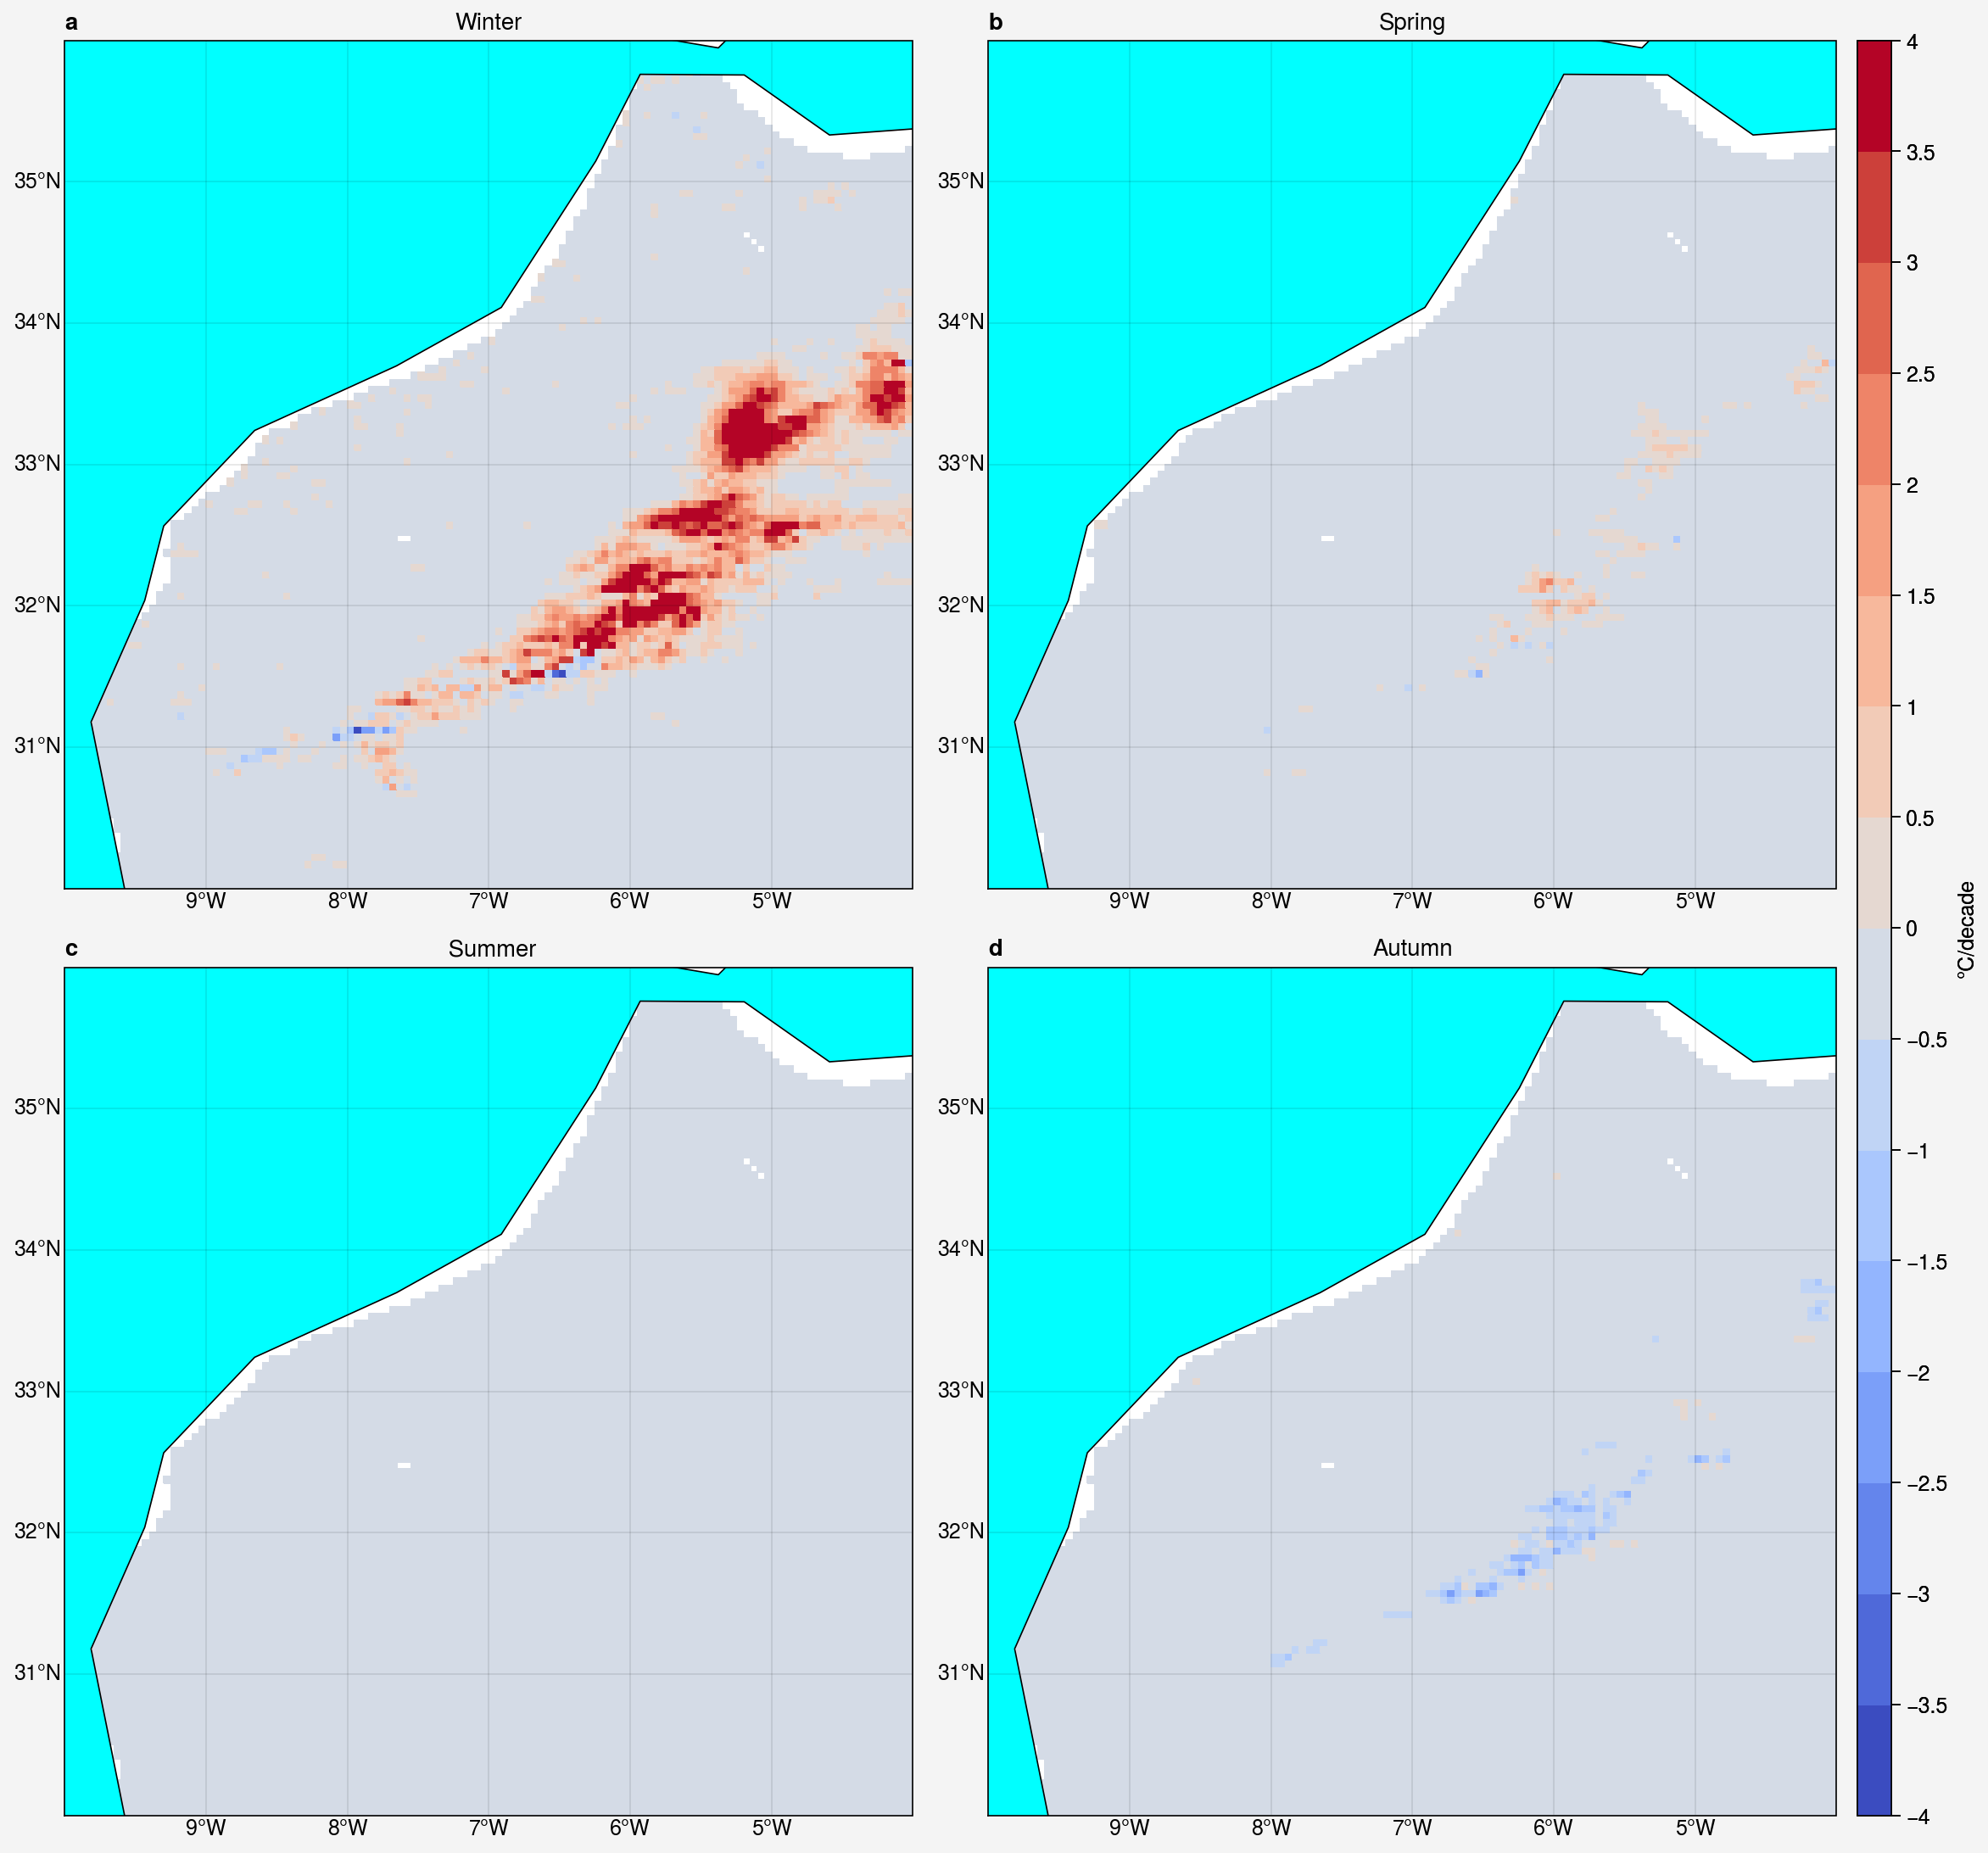

In [120]:
# Plote
# 1) # Masking significativity
signif=np.where(pvalue_scfv<0.05, True,False)

# Levels of scfv for the plot
levels=np.arange(-4,4.5,0.5)
factor=1 # degree per decade

title={1:"Winter",2:"Spring",3:" Summer",4:"Autumn"}
# Producing the map of the trends, excluding the borders of the domain.
f, axs = plot.subplots(proj='cyl',ncols=2, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        aux.lon,aux.lat,
        slope_scfv[i,:,:]*factor,
        levels=levels,
        cmap='coolwarm'  
    )
    ax.format(title=title[i+1])   # font.largesize=='20px'
    
    p = ax.contourf(
    aux.lon,aux.lat,
    signif[i,:,:],
    hatches=["", "//"], alpha=0
    )
    
f.colorbar(m, label= '°C/decade')

axs.format(
    labels=True,
    coast=True, ocean=True, oceancolor='cyan', landcolor='bisque',borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(30, 36), lonlim=(-10, -4)
)

plt.show()

## =================================================================

<h1 style="font-size:1.2rem; color:black;"> Monthly trends   </h1>   

In [ ]:
aux=scfv_subset
N = len(aux.time)
mon_scfv=np.empty(shape=(N,6,aux.shape[1],aux.shape[2]), dtype=float)
print(mon_scfv.shape)

In [ ]:
mon_scfv [:,0,:,:] = aux.where(aux['time.month'] == 1).groupby('time.year').mean(dim='time')
print("done")
mon_scfv [:,1,:,:] = aux.where(aux['time.month'] == 2).groupby('time.year').mean(dim='time')
print("done")
mon_scfv [:,2,:,:] = aux.where(aux['time.month'] == 3).groupby('time.year').mean(dim='time')
print("done")
mon_scfv [:,3,:,:] = aux.where(aux['time.month'] == 4).groupby('time.year').mean(dim='time')
print("done")
"""
mon_scfv [:,4,:,:] = aux.where(aux['time.month'] == 5).groupby('time.year').mean(dim='time')
print("done")
mon_scfv [:,5,:,:] = aux.where(aux['time.month'] == 6).groupby('time.year').mean(dim='time')
print("done")
mon_scfv [:,6,:,:] = aux.where(aux['time.month'] == 7).groupby('time.year').mean(dim='time')
print("done")
mon_scfv [:,7,:,:] = aux.where(aux['time.month'] == 8).groupby('time.year').mean(dim='time')
print("done")
mon_scfv [:,8,:,:] = aux.where(aux['time.month'] == 9).groupby('time.year').mean(dim='time')
print("done")
mon_scfv [:,9,:,:] = aux.where(aux['time.month'] == 10).groupby('time.year').mean(dim='time')
print("done")
"""
mon_scfv [:,4,:,:] = aux.where(aux['time.month'] == 11).groupby('time.year').mean(dim='time')
print("done")
mon_scfv [:,5,:,:] = aux.where(aux['time.month'] == 12).groupby('time.year').mean(dim='time')
print("done")

In [ ]:
# Computing trends    
slope_scfv=np.full(mon_scfv.shape[1:4], np.nan)
pvalue_scfv=np.full(mon_scfv.shape[1:4], np.nan)  
for lon in range(mon_scfv.shape[3]):                        
    print(str(lon)+'/'+str(mon_scfv.shape[3]))
    for lat in range(mon_scfv.shape[2]):
        for mon in range(6):  
            mk_scfv = mk_original_test(seas_scfv[1:,seas,lat,lon])
            slope_scfv[mon][lat][lon] = mk_scfv.slope
            pvalue_scfv[mon][lat][lon] = mk_scfv.p

In [ ]:
print("=========================== slope_scfv ===============================")
print(slope_scfv)
print("=========================== pvalue_scfv ===============================")
print(pvalue_scfv)

In [ ]:
# Plote
# 1) # Masking significativity
signif=np.where(pvalue_scfv<0.05, True,False)

# Levels of scfv for the plot
levels=np.arange(-4,4.5,0.5)
factor=10 # degree per decade

title = {1: "January", 2:"February", 3:"March", 4:"April", 5:"November", 6:"Decmber"}   
# Producing the map of the trends, excluding the borders of the domain.
f, axs = plot.subplots(proj='cyl',ncols=3, nrows=2, share=1, axwidth=5)
for i, ax in enumerate(axs):
    print('i='+str(i))
    print('ax='+str(ax))
    m = ax.pcolormesh(
        scfv.lon,scfv.lat,
        slope_scfv[i,:,:]*factor,
        levels=levels,
        cmap='coolwarm'  
    )
    ax.format(title=title[i+1])   # font.largesize=='20px'
    
    p = ax.contourf(
    scfv.lon,scfv.lat,
    signif[i,:,:],
    hatches=["", "//"], alpha=0
    )
    
f.colorbar(m, label= '°C/decade')

axs.format(
    labels=True,
    coast=True, ocean=True, oceancolor='cyan', landcolor='bisque',borders=False,
    lonlines=1, latlines=1, abc=True, latlim=(28, 36), lonlim=(-10, 0)
)

plt.show()

<h1 style="font-size:1.2rem; color:black;"> Yearly trends   </h1>   

In [ ]:
mean=scfv.mean(dim=['lat','lon'], skipna=True).groupby('time.year').mean(dim='time')

In [ ]:
mean.plot()

## ==================================================================
## ==================================================================